In [3]:
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ExponentialLR, CosineAnnealingLR
import time
import torchvision.models as models
from matplotlib import pyplot as plt
import timm
import optuna
from sklearn.metrics import accuracy_score, f1_score

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA GeForce RTX 3080 Ti
Memory: 12.9 GB


## Load Data

In [5]:
image_transforms = transforms.Compose([
	transforms.RandomHorizontalFlip(),
	transforms.RandomRotation(10),
	transforms.ColorJitter(contrast=0.2, brightness=0.2),
	transforms.Resize((280, 280)),
	transforms.ToTensor(),
	transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [6]:
data_path = './dataset'

dataset = datasets.ImageFolder(root=data_path, transform=image_transforms)
len(dataset)

2310

In [7]:
dataset.classes

['F_Breakage', 'F_Crushed', 'F_Normal', 'R_Breakage', 'R_Crushed', 'R_Normal']

In [8]:
train_size = int(0.75 * len(dataset))
test_size = len(dataset) - train_size
train_size, test_size

(1732, 578)

In [9]:
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

batch_size = 64

train_loader =  DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [10]:
for image, label in train_loader:
	print(image.shape)
	print(label.shape)
	break

torch.Size([64, 3, 280, 280])
torch.Size([64])


In [11]:
label[50], image[1].shape

(tensor(1), torch.Size([3, 280, 280]))

In [12]:
image[1].permute(1,2,0).shape

torch.Size([280, 280, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


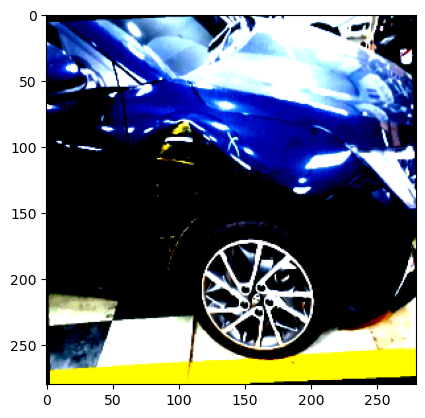

In [13]:
plt.imshow(image[50].permute(1,2,0))
plt.show()

In [14]:
image.size(0), len(train_loader.dataset)

(64, 1732)

In [15]:
for images, labels in train_loader:
    print(f"Image shape: {images.shape}")
    break

Image shape: torch.Size([64, 3, 280, 280])


In [16]:
# Training function for Optuna
def train_model_optuna(model, criterion, optimizer, epochs, device, train_loader, val_loader, trial=None):
    model.to(device)
    best_val_acc = 0.0
    
    for epoch in range(epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        train_correct = 0
        train_total = 0
        
        for batch, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()
        
        # Validation phase
        model.eval()
        val_correct = 0
        val_total = 0
        val_loss = 0.0
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        train_acc = train_correct / train_total
        val_acc = val_correct / val_total
        epoch_loss = running_loss / len(train_loader.dataset)
        val_epoch_loss = val_loss / len(val_loader.dataset)
        
        print(f'Epoch [{epoch + 1}/{epochs}]')
        print(f'  Train Loss: {epoch_loss:.4f}, Train Acc: {train_acc:.4f}')
        print(f'  Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_acc:.4f}')
        
        # Update best validation accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
        
        # Report intermediate results to Optuna for pruning
        if trial:
            trial.report(val_acc, epoch)
            if trial.should_prune():
                raise optuna.exceptions.TrialPruned()
    
    return best_val_acc

In [17]:
model = models.efficientnet_v2_m(pretrained=True)
model.classifier[1].in_features

c:\Users\poohz\anaconda3\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\poohz\anaconda3\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


1280

### Model 2: Transfer Learning with ResNet50

In [18]:
# Updated model class
class CarDamageClassResNet50(nn.Module):
    def __init__(self, num_class, dropout_rate=0.5):
        super().__init__()
        self.model = models.resnet50(weights='DEFAULT')
        for param in self.model.parameters():
            param.requires_grad = False
        for param in self.model.layer4.parameters():
            param.requires_grad = True
        self.model.fc = nn.Sequential(
            nn.Dropout(dropout_rate),
            nn.Linear(self.model.fc.in_features, num_class)
        )
    
    def forward(self, x):
        return self.model(x)

### Hyperparameter Tuning

In [19]:
# Objective function for Optuna optimization
def objective(trial):
    # Hyperparameters to tune
    params = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True),
        'dropout_rate': trial.suggest_float('dropout_rate', 0.1, 0.7),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-2, log=True),
        'optimizer_name': trial.suggest_categorical('optimizer_name', ['Adam', 'SGD', 'AdamW'])
    }
    
    # SGD-specific parameters
    if params['optimizer_name'] == 'SGD':
        params['momentum'] = trial.suggest_float('momentum', 0.8, 0.99)
        params['nesterov'] = trial.suggest_categorical('nesterov', [True, False])
    
    print(f"Trial {trial.number}: Testing parameters {params}")
    
    try:
        # Create model
        model = CarDamageClassResNet50(
            num_class=num_classes,
            dropout_rate=params['dropout_rate']
        )
        
        # Create optimizer
        if params['optimizer_name'] == 'Adam':
            optimizer = optim.Adam(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
        elif params['optimizer_name'] == 'SGD':
            optimizer = optim.SGD(
                model.parameters(),
                lr=params['learning_rate'],
                momentum=params['momentum'],
                weight_decay=params['weight_decay'],
                nesterov=params['nesterov']
            )
        elif params['optimizer_name'] == 'AdamW':
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params['learning_rate'],
                weight_decay=params['weight_decay']
            )
        
        # Loss function
        criterion = nn.CrossEntropyLoss()
        
        # Train the model (using fixed 15 epochs)
        best_val_acc = train_model_optuna(
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            epochs=15,  # Fixed epochs
            device=device,
            train_loader=train_loader,
            val_loader=val_loader,
            trial=trial
        )
        
        return best_val_acc
        
    except Exception as e:
        print(f"Trial {trial.number} failed with error: {e}")
        return 0.0

In [20]:
# Main hyperparameter tuning function
def run_hyperparameter_tuning(n_trials=50):
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=5,
            interval_steps=1
        )
    )
    
    # Run optimization
    study.optimize(objective, n_trials=n_trials)
    
    # Print results
    print("Best parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\nBest validation accuracy: {study.best_value:.4f}")
    
    # Get top 5 trials
    print("\nTop 5 trials:")
    for i, trial in enumerate(study.trials_dataframe().nlargest(5, 'value').iterrows()):
        print(f"  Trial {i+1}: {trial[1]['value']:.4f}")
    
    return study

In [21]:
# Main hyperparameter tuning function
def run_hyperparameter_tuning(n_trials=50):
    # Create Optuna study
    study = optuna.create_study(
        direction='maximize',
        pruner=optuna.pruners.MedianPruner(
            n_startup_trials=5,
            n_warmup_steps=5,
            interval_steps=1
        )
    )
    
    # Run optimization
    study.optimize(objective, n_trials=n_trials)
    
    # Print results
    print("Best parameters:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    
    print(f"\nBest validation accuracy: {study.best_value:.4f}")
    
    # Get top 5 trials
    print("\nTop 5 trials:")
    for i, trial in enumerate(study.trials_dataframe().nlargest(5, 'value').iterrows()):
        print(f"  Trial {i+1}: {trial[1]['value']:.4f}")
    
    return study

In [22]:
# Function to get best parameters
def get_best_parameters(study):
    """
    Extract and return the best parameters found by Optuna
    """
    best_params = study.best_params
    print("Best parameters found:")
    print("="*50)
    for key, value in best_params.items():
        print(f"{key}: {value}")
    print("="*50)
    print(f"Best validation accuracy: {study.best_value:.4f}")
    
    return best_params

In [23]:
num_classes = len(dataset.classes)  # Fixed variable name to match what's used in objective function

model = CarDamageClassResNet50(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(filter(lambda p : p.requires_grad, model.parameters()), lr=0.001)

# Create validation split from test_loader for hyperparameter tuning
val_size = len(test_dataset) // 2
test_size_new = len(test_dataset) - val_size
val_dataset, test_dataset_new = random_split(test_dataset, [val_size, test_size_new])

val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Test training function without trial object (pass None instead of True)
train_model_optuna(model, criterion, optimizer, epochs=3, train_loader=train_loader, val_loader=val_loader, device=device,
                  trial=None)  # Changed from trial=True to trial=None

# Run hyperparameter tuning
study = run_hyperparameter_tuning(n_trials=3)

# Get best parameters
best_params = get_best_parameters(study)
best_params

Epoch [1/3]
  Train Loss: 0.9079, Train Acc: 0.6484
  Val Loss: 0.8746, Val Acc: 0.7093
Epoch [2/3]
  Train Loss: 0.4847, Train Acc: 0.8089
  Val Loss: 0.7497, Val Acc: 0.6886


[I 2026-02-16 19:32:13,334] A new study created in memory with name: no-name-c2f8b511-3150-4c0d-ab8f-78354249e6db


Epoch [3/3]
  Train Loss: 0.3568, Train Acc: 0.8770
  Val Loss: 0.6385, Val Acc: 0.7889
Trial 0: Testing parameters {'learning_rate': 0.0005555133005095272, 'dropout_rate': 0.5506022480362629, 'weight_decay': 0.0025079093935506526, 'optimizer_name': 'Adam'}
Epoch [1/15]
  Train Loss: 1.0023, Train Acc: 0.5970
  Val Loss: 1.1208, Val Acc: 0.6644
Epoch [2/15]
  Train Loss: 0.4866, Train Acc: 0.8129
  Val Loss: 0.4985, Val Acc: 0.7889
Epoch [3/15]
  Train Loss: 0.3269, Train Acc: 0.8863
  Val Loss: 0.5771, Val Acc: 0.7855
Epoch [4/15]
  Train Loss: 0.2387, Train Acc: 0.9169
  Val Loss: 0.7416, Val Acc: 0.7543
Epoch [5/15]
  Train Loss: 0.2438, Train Acc: 0.9197
  Val Loss: 0.5158, Val Acc: 0.8166
Epoch [6/15]
  Train Loss: 0.2264, Train Acc: 0.9319
  Val Loss: 0.7189, Val Acc: 0.7958
Epoch [7/15]
  Train Loss: 0.1503, Train Acc: 0.9503
  Val Loss: 0.7665, Val Acc: 0.7578
Epoch [8/15]
  Train Loss: 0.1489, Train Acc: 0.9573
  Val Loss: 0.6832, Val Acc: 0.8131
Epoch [9/15]
  Train Loss: 0.1

[I 2026-02-16 19:47:43,091] Trial 0 finished with value: 0.8269896193771626 and parameters: {'learning_rate': 0.0005555133005095272, 'dropout_rate': 0.5506022480362629, 'weight_decay': 0.0025079093935506526, 'optimizer_name': 'Adam'}. Best is trial 0 with value: 0.8269896193771626.


Epoch [15/15]
  Train Loss: 0.2337, Train Acc: 0.9278
  Val Loss: 0.5743, Val Acc: 0.8270
Trial 1: Testing parameters {'learning_rate': 2.183175992233879e-05, 'dropout_rate': 0.18896395290685192, 'weight_decay': 4.857251270551032e-05, 'optimizer_name': 'SGD', 'momentum': 0.8876206784277452, 'nesterov': False}
Epoch [1/15]
  Train Loss: 1.7828, Train Acc: 0.2165
  Val Loss: 1.7793, Val Acc: 0.2353
Epoch [2/15]
  Train Loss: 1.7845, Train Acc: 0.1969
  Val Loss: 1.7723, Val Acc: 0.2388
Epoch [3/15]
  Train Loss: 1.7782, Train Acc: 0.2413
  Val Loss: 1.7702, Val Acc: 0.2768
Epoch [4/15]
  Train Loss: 1.7765, Train Acc: 0.2413
  Val Loss: 1.7773, Val Acc: 0.2561
Epoch [5/15]
  Train Loss: 1.7726, Train Acc: 0.2419
  Val Loss: 1.7685, Val Acc: 0.2491
Epoch [6/15]
  Train Loss: 1.7712, Train Acc: 0.2540
  Val Loss: 1.7677, Val Acc: 0.2630
Epoch [7/15]
  Train Loss: 1.7701, Train Acc: 0.2540
  Val Loss: 1.7649, Val Acc: 0.2768
Epoch [8/15]
  Train Loss: 1.7636, Train Acc: 0.2644
  Val Loss: 1

[I 2026-02-16 20:02:59,696] Trial 1 finished with value: 0.29411764705882354 and parameters: {'learning_rate': 2.183175992233879e-05, 'dropout_rate': 0.18896395290685192, 'weight_decay': 4.857251270551032e-05, 'optimizer_name': 'SGD', 'momentum': 0.8876206784277452, 'nesterov': False}. Best is trial 0 with value: 0.8269896193771626.


Epoch [15/15]
  Train Loss: 1.7516, Train Acc: 0.2777
  Val Loss: 1.7473, Val Acc: 0.2630
Trial 2: Testing parameters {'learning_rate': 1.18343824474948e-05, 'dropout_rate': 0.3185380193986677, 'weight_decay': 0.0001371743183645845, 'optimizer_name': 'AdamW'}
Epoch [1/15]
  Train Loss: 1.7695, Train Acc: 0.2494
  Val Loss: 1.7459, Val Acc: 0.3460
Epoch [2/15]
  Train Loss: 1.7164, Train Acc: 0.3655
  Val Loss: 1.6983, Val Acc: 0.3875
Epoch [3/15]
  Train Loss: 1.6540, Train Acc: 0.4255
  Val Loss: 1.6232, Val Acc: 0.4083
Epoch [4/15]
  Train Loss: 1.5664, Train Acc: 0.4532
  Val Loss: 1.5292, Val Acc: 0.4083
Epoch [5/15]
  Train Loss: 1.4534, Train Acc: 0.4861
  Val Loss: 1.3973, Val Acc: 0.4810
Epoch [6/15]
  Train Loss: 1.3284, Train Acc: 0.5427
  Val Loss: 1.2835, Val Acc: 0.5571
Epoch [7/15]
  Train Loss: 1.2108, Train Acc: 0.6010
  Val Loss: 1.1691, Val Acc: 0.5709
Epoch [8/15]
  Train Loss: 1.1087, Train Acc: 0.6513
  Val Loss: 1.0845, Val Acc: 0.6401
Epoch [9/15]
  Train Loss: 1

[I 2026-02-16 20:18:48,500] Trial 2 finished with value: 0.7162629757785467 and parameters: {'learning_rate': 1.18343824474948e-05, 'dropout_rate': 0.3185380193986677, 'weight_decay': 0.0001371743183645845, 'optimizer_name': 'AdamW'}. Best is trial 0 with value: 0.8269896193771626.


Epoch [15/15]
  Train Loss: 0.6249, Train Acc: 0.7933
  Val Loss: 0.7189, Val Acc: 0.7128
Best parameters:
  learning_rate: 0.0005555133005095272
  dropout_rate: 0.5506022480362629
  weight_decay: 0.0025079093935506526
  optimizer_name: Adam

Best validation accuracy: 0.8270

Top 5 trials:
  Trial 1: 0.8270
  Trial 2: 0.7163
  Trial 3: 0.2941
Best parameters found:
learning_rate: 0.0005555133005095272
dropout_rate: 0.5506022480362629
weight_decay: 0.0025079093935506526
optimizer_name: Adam
Best validation accuracy: 0.8270


{'learning_rate': 0.0005555133005095272,
 'dropout_rate': 0.5506022480362629,
 'weight_decay': 0.0025079093935506526,
 'optimizer_name': 'Adam'}